# Identify, Retrieve and  Export  Near-Cloud-Free Landsat Images 

### Fei Zhang @Geoscience Australia

Sept 2016

## Introduction


### Key Topics: 

1) 
2) 

## Interactive Computing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='GetData')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Datacube Products List 
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [3]:
df_prodlist = dc.list_products()

df_prodlist.shape

(32, 15)

In [4]:
df_prodlist.head()

,name,description,product_type,sat_path,format,lon,platform,sat_row,instrument,time,lat,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
36,bom_rainfall_grids,Interpolated Rain Gauge Precipitation 1-Day Au...,rainfall,NaN,NETCDF,NaN,BoM,NaN,rain gauge,None,NaN,EPSG:4326,"[-0.05, 0.05]",None,"(latitude, longitude)"
32,dsm1sv10,DSM 1sec Version 1.0,DEM,NaN,ENVI,NaN,SRTM,NaN,SIR,None,NaN,EPSG:4326,"[-0.00027777777778, 0.00027777777778]",None,"(latitude, longitude)"
27,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til...",fractional_cover,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"
2,ls5_level1_scene,Landsat 5 Level 1 At-sensor Radiance 25 metre,level1,NaN,GeoTiff,NaN,LANDSAT_5,NaN,TM,None,NaN,NaN,NaN,NaN,NaN
6,ls5_nbar_albers,"Landsat 5 Surface Reflectance NBAR 25 metre, 1...",nbar,NaN,NetCDF,NaN,LANDSAT_5,NaN,TM,None,NaN,EPSG:3577,"[-25, 25]","[100000.0, 100000.0]","(y, x)"


## Measurements List of the Products

- Each of the datacube products may have multiple measurements.

- Measurements are related to the sensors characteristics,  also known as _bands_ in the remote-sensing domain.

- _bands_ comes from electromagnetic wave spectral ranges, generally include Red-Green-Blue (RGB). 

In [5]:
df_measlist = dc.list_measurements()

df_measlist.shape

(99, 7)

In [6]:
df_measlist.head(2)

,,aliases,dtype,flags_definition,name,nodata,spectral_definition,units
product,measurement,,,,,,,
bom_rainfall_grids,rainfall,NaN,float32,NaN,rainfall,-999,NaN,mm
dsm1sv10,elevation,NaN,float32,NaN,elevation,NaN,NaN,metre


## Retrieving data


In [7]:
#To see the function signature?
#dc.load?

# Where?
xp=(149.07, 149.17); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond
xp=(149.28, 149.53); yp=(-34.98,  -35.25)  # Lake George small area
                
# When? a time range
tp=('2010-01', '2016-12-31')
#what product type?
prod_type='ls8_nbar_albers'
# associated pq product code
pq_prod_type = prod_type.replace('nbar','pq')

# output grid and resolution?
v_output_crs=None; v_resolution=None   #None if AGDC default

# v_output_crs='EPSG:3112'; v_resolution=(-25,25)  #LCC 3112, Albers 3577
# output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))

In [8]:
itime=1

def show_images(nbar, itime):
    """ Display single band images; select a time-slice of the imagery stack
          use pandas-style slicing to select a time period
    """
    
    print ("Showing images acquired in datetime ", nbar.time.values[itime])
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(16,14) )
    
    plt.subplot( 1,3,1 )
    plt.imshow(red_img)#, cmap='gray')
    plt.title("Red band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='red sensor measurement');

    
    plt.subplot( 1,3,2 )
    plt.imshow(green_img)   # plotting the subset data directly
    #plt.imshow(green_img, cmap='gray')
    plt.title("Green band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='green sensor measurement');


    plt.subplot( 1,3,3 )
    plt.imshow(blue_img)   # plotting the subset data directly
    #plt.imshow(blue_img, cmap='gray')
    plt.title("Blue band"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.3, label='blue sensor measurement');

    return


In [9]:
# define a scale function to strech an image 

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    """
    Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    replacing 'nan_val' values with NaN's.
    #f_arr = 1.0*arr #.astype('float')    # required for NaN's 
    """
  
    f_arr = arr.astype('float')
    #f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    
    return f_arr


In [10]:
def make_rgb_images(nbar, itime, outfname=None):
    """
    Create a RGB image using bands acquired at itime
    """
    print ("RGB image acquired in datetime ", nbar.time.values[itime])
        
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)


    plt.figure( figsize=(10,10) )
    
    red_img=nbar.red.isel(time=itime)
    green_img=nbar.green.isel(time=itime)
    blue_img = nbar.blue.isel(time=itime)
    y_size = red_img.shape[0]; x_size = red_img.shape[1]

    print (y_size,x_size)
    #print red_img.shape

    sB1data = scale_array(red_img, 99.0, 0, 255, -999)
    sB2data = scale_array(green_img, 99.0, 0, 255, -999)
    sB3data = scale_array(blue_img, 99.0, 0, 255, -999)


    rgb_image = np.zeros((y_size, x_size, 3), dtype='uint8')
    rgb_image[:,:,0] = sB1data; 
    rgb_image[:,:,1] = sB2data; 
    rgb_image[:,:,2] = sB3data
    
    if outfname is None:
        title_str= 'Landsat Image over the Area: %s, %s'% (str(xp), str(yp))
        plt.title(title_str)
        plt.ylabel('northing'); plt.xlabel('easting');
        plt.imshow(rgb_image, interpolation='none')
    else:
        plt.imsave(outfname, rgb_image)
    
#     output_figure_name = 'nbar_nature_color.jpg'
#     plt.savefig(output_figure_name, dpi=400)

# Export to geotiff raster file

In [11]:
import rasterio

DEFAULT_PROFILE = {
    'blockxsize': 256,
    'blockysize': 256,
    'compress': 'lzw',
    'driver': 'GTiff',
    'interleave': 'band',
    'nodata': 0.0,
    'photometric': 'RGBA',
    'tiled': True}


def write_geotiff(filename, dataset, time_index=None, profile_override=None):
    """
    Write an xarray dataset to a geotiff

    :attr bands: ordered list of dataset names
    :attr time_index: time index to write to file
    :attr dataset: xarray dataset containing multiple bands to write to file
    :attr profile_override: option dict, overrides rasterio file creation options.
    """
    profile_override = profile_override or {}

    dtypes = {val.dtype for val in dataset.data_vars.values()}
    assert len(dtypes) == 1  # Check for multiple dtypes

    profile = DEFAULT_PROFILE.copy()
    profile.update({
        'width': dataset.dims[dataset.crs.dimensions[1]],
        'height': dataset.dims[dataset.crs.dimensions[0]],
        'affine': dataset.affine,
        'crs': dataset.crs.crs_str,
        'count': len(dataset.data_vars),
        'dtype': str(dtypes.pop()),
        'nodata': dataset.red.nodata
    })
    profile.update(profile_override)

    with rasterio.open(filename, 'w', **profile) as dest:
        for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
            dest.write(data.isel(time=time_index).data, bandnum)

In [12]:
# export dataset xarray.Dataset
import os

def export_datasets(ds, fn_prefix):
    for itime in xrange (0,len(ds.time)):
        fntime=str(ds.time.values[itime])[:19].replace(':','')
        fname ="%s_%s.tiff"%(fn_prefix,fntime)
        fname2="%s_%s.png"%(fn_prefix,fntime)
        
        path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
        path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)

        write_geotiff(path2fname,ds, itime)
        
        make_rgb_images(ds, itime, path2fname2 )
        
        

## Group  by solar day function

- There is a bit of overlap between two adjacent scenes ("cut").
- To remove the overlap duplication, we combine the data slices with datetimes less than a minute apart.  
- Now we have fewer timeslices than found previously without solar-day-grouping
- According to Landsat cycle 16 days, 365/16 = 22 re-visit a place at least per year 

(For some region like Canberra, there will be overlap between passes)
Can be checked in the Clear Observation Layer at: http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm

## Clean and near-cloudless images in AGDC


### Derive information products 

### Must identify and remove invalid observations: cloud, shadow, satuared pixels

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

In [13]:
# Select best RGB NDVI NDWI images: eg,70% good valid pixels

Good_Pixels_Pct=70

In [15]:
#  retrieve a subset of bands
#bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, group_by='solar_day',
#        measurements=['red', 'nir', 'green', 'swir1','blue'])

# retrieve all bands
bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, group_by='solar_day')
red = bands.red.where(bands.red != bands.red.attrs['nodata'])
nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])
                    
green = bands.green.where(bands.green != bands.green.attrs['nodata'])
swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])

# Retrieve the associated Pixel Quality datasets. pq has issue with group_by_solar_day 
# They may not match all the Nbar products
pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day') #, fuse_func='')

cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality


The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

We can look at the data by name directly, or through the `data_vars` dictionary:


In [16]:
# inspect the xarray.Datasets 

bands

print(bands.time.min())
print(bands.time.max())
print (bands.crs)
print(bands.data_vars)
print (bands.coords)

#nbar vs pq
print (bands.dims)
print (pq.dims)

print(bands.geobox); 
print(pq.geobox)


print (bands.indexes)
print (pq.indexes)


<xarray.DataArray 'time' ()>
numpy.datetime64('2013-04-19T10:00:00.000000000+1000')
<xarray.DataArray 'time' ()>
numpy.datetime64('2016-05-29T10:00:00.000000000+1000')
EPSG:3577
Data variables:
    coastal_aerosol  (time, y, x) int16 604 524 433 520 494 481 491 515 550 ...
    blue             (time, y, x) int16 654 550 491 513 583 551 574 620 598 ...
    green            (time, y, x) int16 1049 915 835 987 908 841 853 926 ...
    red              (time, y, x) int16 1343 1150 1038 1099 1204 1091 1124 ...
    nir              (time, y, x) int16 2808 2674 2224 2406 2163 1667 1615 ...
    swir1            (time, y, x) int16 3254 2919 2664 2996 2958 2526 2317 ...
    swir2            (time, y, x) int16 2304 2053 1512 1659 1825 1659 1688 ...
Coordinates:
  * time     (time) datetime64[ns] 2013-04-19 2013-04-26 2013-05-21 ...
  * y        (y) float64 -3.926e+06 -3.926e+06 -3.926e+06 -3.926e+06 ...
  * x        (x) float64 1.565e+06 1.565e+06 1.565e+06 1.565e+06 1.565e+06 ...
Frozen(SortedKey

In [17]:
print ('No data values', bands.red.nodata)

('No data values', -999)


### Compute Indexes: NDVI and NDWI

#### Numpy array arithmetics without looping

In [18]:

# Normalized Differenc Vegetation Index: Red and near Infrared bands

ndvi = ((nir - red) / (nir + red)).where(cloud_free)

# Normalized Differenc Water Index: Green and Shortwave Infrared Bands

ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

#ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

ndvi.shape


(70, 1314, 1065)

In [19]:
ndwi.shape

(70, 1314, 1065)

In [ ]:
# skip ndvi plots 
#ndvi.plot(col='time', col_wrap=6)

###  Weed out the low quality images.

In [20]:
# xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels

cloudfreeRatio = 0.01*Good_Pixels_Pct # threshold of cloud pixel 80% ??

mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

print(mostly_cloud_free)

# How many images selected?

print(mostly_cloud_free.sum().values)

<xarray.DataArray 'pixelquality' (time: 70)>
array([False,  True, False, False, False,  True, False,  True,  True,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True, False, False,  True, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False], dtype=bool)
Coordinates:
  * time     (time) datetime64[ns] 2013-04-19 2013-05-21 2013-06-06 ...
18


In [21]:

seltimes=[]
for itime in xrange(0,len(mostly_cloud_free)):  
    if mostly_cloud_free[itime].values:
        print (itime, mostly_cloud_free[itime].values, mostly_cloud_free[itime].time.values )
        seltimes.append(mostly_cloud_free[itime].time.values)
        
print seltimes  

(1, array(True, dtype=bool), numpy.datetime64('2013-05-21T10:00:00.000000000+1000'))
(5, array(True, dtype=bool), numpy.datetime64('2013-07-24T10:00:00.000000000+1000'))
(7, array(True, dtype=bool), numpy.datetime64('2013-08-25T10:00:00.000000000+1000'))
(8, array(True, dtype=bool), numpy.datetime64('2013-09-10T10:00:00.000000000+1000'))
(15, array(True, dtype=bool), numpy.datetime64('2013-12-31T11:00:00.000000000+1100'))
(16, array(True, dtype=bool), numpy.datetime64('2014-01-16T11:00:00.000000000+1100'))
(19, array(True, dtype=bool), numpy.datetime64('2014-03-21T11:00:00.000000000+1100'))
(22, array(True, dtype=bool), numpy.datetime64('2014-05-08T10:00:00.000000000+1000'))
(24, array(True, dtype=bool), numpy.datetime64('2014-06-09T10:00:00.000000000+1000'))
(28, array(True, dtype=bool), numpy.datetime64('2014-08-12T10:00:00.000000000+1000'))
(31, array(True, dtype=bool), numpy.datetime64('2014-09-29T10:00:00.000000000+1000'))
(35, array(True, dtype=bool), numpy.datetime64('2014-12-18

In [27]:
def filter_export_datasets(ds, fn_prefix, times):
    for itime in xrange(0,len(ds.time)):
        #print (ds.time.values[itime])
        if ds.time.values[itime] in times:
            print (itime)
            
            fntime=str(ds.time.values[itime])[:19].replace(':','')
            fname ="%s_%s.tiff"%(fn_prefix,fntime)
            fname2="%s_%s.png"%(fn_prefix,fntime)
            
            path2fname=os.path.join("/short/v10/fxz547/Dexport",fname)
            path2fname2 =os.path.join("/short/v10/fxz547/Dexport",fname2)

            write_geotiff(path2fname,ds, itime)

            make_rgb_images(ds, itime, path2fname2 )
        

In [28]:
filter_export_datasets(bands,"CleanImages_LakeGorge",seltimes)

2
('RGB image acquired in datetime ', numpy.datetime64('2013-05-21T10:00:00.000000000+1000'))
(1314, 1065)
6
('RGB image acquired in datetime ', numpy.datetime64('2013-07-24T10:00:00.000000000+1000'))
(1314, 1065)
8
('RGB image acquired in datetime ', numpy.datetime64('2013-08-25T10:00:00.000000000+1000'))
(1314, 1065)
9
('RGB image acquired in datetime ', numpy.datetime64('2013-09-10T10:00:00.000000000+1000'))
(1314, 1065)
18
('RGB image acquired in datetime ', numpy.datetime64('2013-12-31T11:00:00.000000000+1100'))
(1314, 1065)
19
('RGB image acquired in datetime ', numpy.datetime64('2014-01-16T11:00:00.000000000+1100'))
(1314, 1065)
26
('RGB image acquired in datetime ', numpy.datetime64('2014-03-21T11:00:00.000000000+1100'))
(1314, 1065)
32
('RGB image acquired in datetime ', numpy.datetime64('2014-05-08T10:00:00.000000000+1000'))
(1314, 1065)
35
('RGB image acquired in datetime ', numpy.datetime64('2014-06-09T10:00:00.000000000+1000'))
(1314, 1065)
39
('RGB image acquired in datet

In [ ]:
!ffmpeg -r 1 -pattern_type glob -i 'Dexport/CleanImages_LakeGorge_*.png' -c:v libx264 LS78.mp4

('RGB image acquired in datetime ', numpy.datetime64('2016-02-07T11:00:00.000000000+1100'))
(1314, 1065)


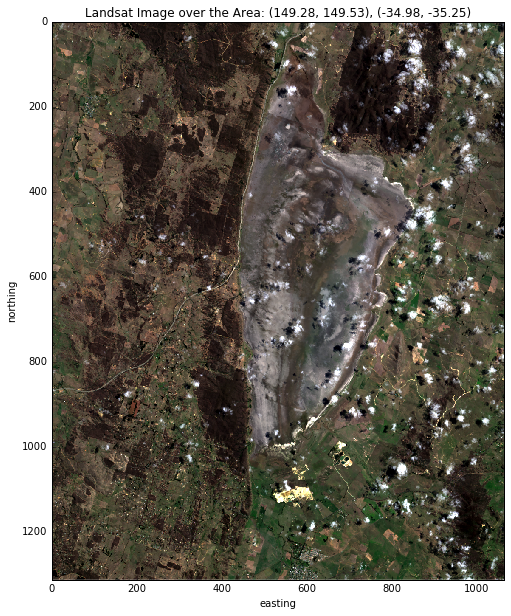

In [37]:
# Display the nearly cloud free images [0, 8, 9, 11, 12, 20, 24, 26, 30, 32, 34]
it=81
make_rgb_images(bands, it)


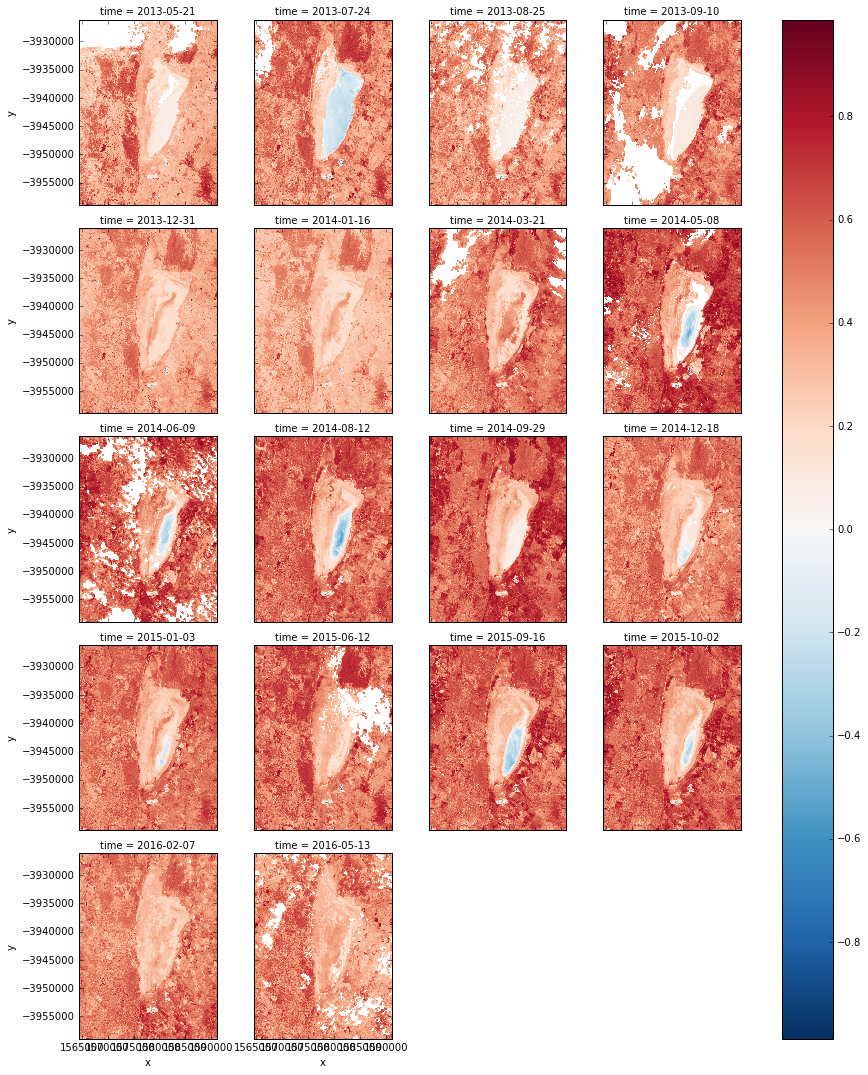

In [26]:
# Apply the time-dim mask to the 3D-array (time, x, y)
mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
mostly_good_ndvi.plot(col='time', col_wrap=4)

In [ ]:
mostly_good_ndvi

In [ ]:

How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff?

red, green, blue, swir1

NDVI

NDWI



In [ ]:
How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff

In [ ]:
How to export xarray.DataArray (time: 11, y: 490, x: 420) into geotiff

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

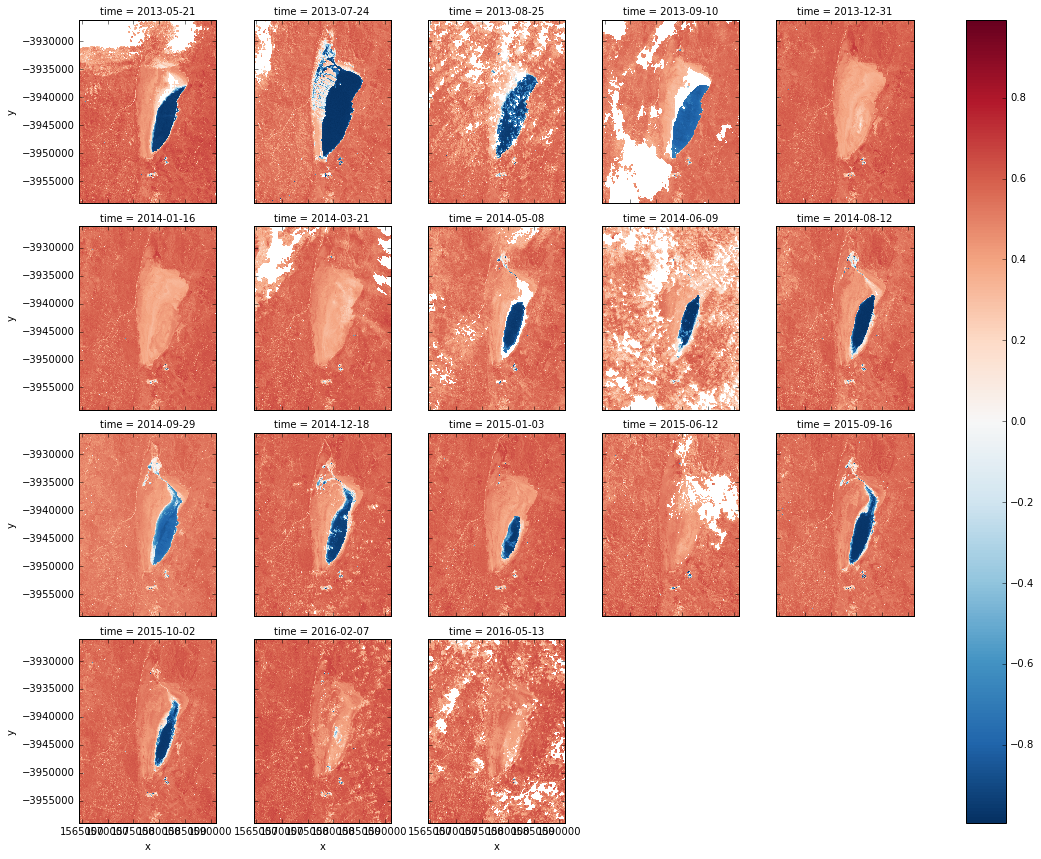

In [34]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

In [ ]:
stop

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm


## DSM dataset indexed in DC

In [35]:
# Canberra   grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35))
grid = dc.load(product='dsm1sv10', x=xp, y=yp)
grid.elevation

<xarray.DataArray 'elevation' (time: 1, latitude: 973, longitude: 901)>
array([[[ 657.14056396,  658.74005127,  660.5043335 , ...,  881.71478271,
          887.07427979,  892.04284668],
        [ 657.50531006,  657.65234375,  658.50317383, ...,  882.8760376 ,
          888.53692627,  893.98974609],
        [ 657.49334717,  656.13665771,  655.90460205, ...,  883.18762207,
          889.09014893,  894.74719238],
        ..., 
        [ 789.00067139,  787.67504883,  786.97906494, ...,  756.51507568,
          756.50128174,  755.74499512],
        [ 791.4430542 ,  789.95776367,  789.00927734, ...,  757.70788574,
          758.2142334 ,  757.6418457 ],
        [ 794.21612549,  792.20251465,  790.60571289, ...,  758.85961914,
          759.41107178,  759.01928711]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2000-02-17T08:33:00
  * latitude   (latitude) float64 -34.98 -34.98 -34.98 -34.98 -34.98 -34.98 ...
  * longitude  (longitude) float64 149.3 149.3 149.3 149.3 149.

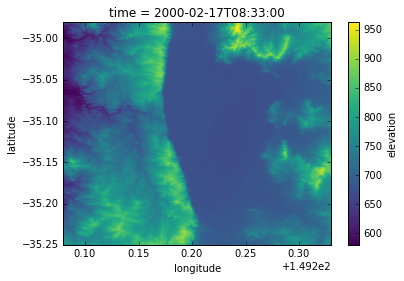

In [36]:
grid.elevation[0].plot()

## Re-projection and Re-sampling 

In [ ]:
stop

# http://spatialreference.org/ref/epsg/gda94-geoscience-australia-lambert/ 3112
# EPSG:3577: GDA94 / Australian Albers
# EPSG:3112 GDA94 / Geoscience Australia Lambert

In [ ]:
albers_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3577', resolution=(-25,25))

albers_grid.elevation.shape

In [ ]:
albers_grid.elevation[0].plot()

In [ ]:
lcc_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.25, -35.35), 
                      output_crs='EPSG:3112', resolution=(-25,25))

lcc_grid.elevation.shape
lcc_grid.elevation[0].plot()

In [ ]:
geosphere_grid = dc.load(product='dsm1sv10', x=(149.07, 149.17), y=(-35.35,-35.25),output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))

geosphere_grid.elevation.shape


In [ ]:
query = {
    'lat': (-35.2, -35.4),
    'lon': (149.0, 149.2),
}

dsmgrid=dc.load(product='dsm1sv10', output_crs='EPSG:4326', resolution=(-0.00025, 0.00025), **query)

dsmgrid.elevation.shape

In [ ]:
dsmgrid.elevation[0].plot()

In [ ]:
#landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.00025, 0.00025))
landsat = dc.load(product='ls5_nbar_albers', x=(149.25, 149.35),y=(-35.25, -35.35), time=('2011-01-01', '2011-03-01'), output_crs='EPSG:4326', resolution=(-0.001, 0.001))

landsat.green[0].plot()

In [ ]:
landsat

In [ ]:
!getfacl /g/data/v10/projects/ingest_test_data/milestone1/dsm1sv1_0_Clean/